<a href="https://colab.research.google.com/github/xdderekchen/NLPs/blob/master/Test_API_IXINBUY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demonstation of Web API of ixinbuy.com

ixinbuy.com provides Web API for users to access the powerful block-chain based services.

This post has 2 purposes:
 1. Samples for API calls
 2. Testing of API and the webservice

## 1.1. Version 1

In this version, we will test the following 3 functions
 * **(POST)** http://ixinbuy.com/register
 * **(POST)** http://ixinbuy.com/uploaddata
 * **(GET)**  http://ixinbuy.com/getshareddata

### register

In [0]:
# http://ixinbuy.com/register

import requests
import json

URL = "http://ixinbuy.com/register"

payload = {"device_id":"XD12345"}

#Passing payload as dict
responce = requests.post(URL, data = payload)
print(responce.status_code)
print(responce.text)


#Passing payload as json string
payload = '{"device_id":"XD12345"}'
responce = requests.post(URL, json = json.loads(payload))
print(responce.status_code)
print(responce.text)

200
true
200
true


### uploaddata (single)

In [0]:
# http://ixinbuy.com/uploaddata

import requests
import json

URL = "http://ixinbuy.com/uploaddata"

# data_type": 2 for COVID19 data
payload = {
   "data_type": 2, 
   "data": {
       "device_id": "XD12345",
       "device_data00": {
          "date": "2020-01-07",
          "province_state": "Shanghai00",
          "country_region": "Mainland China",
          "last_update": "2020-03-07T10:43:02",
          "confirmed":100,
          "deaths": 7,
          "recovered": 1237,
          "latitude":  23.3417,
          "longitude": 113.4244
       }
   }
}


#Passing payload as dict
responce = requests.post(URL, json = payload)
print(responce.status_code)
print(responce.text)


200
{"message":"Cannot read property 'province_state' of undefined","stack":"TypeError: Cannot read property 'province_state' of undefined\n    at /home/uadmin/fabric-samples/medicalnet/fabric_api/routes/routes.js:58:60"}


### uploaddata (batch)

In here, we will pull real data from John Hopkins and invoke the webservice call.

The data of John Hopkins is at "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports"
    

In [2]:
import pandas as pd
import os
import requests
import json

def uploaddata(source_file, URL, data_date):
    print("processing: ", source_file)
    df = pd.read_csv(source_file)
   
    df.rename(columns={'Province/State': 'province_state',
                       'Country/Region': 'country_region',
                       'Last Update'   : 'last_update',
                       'Confirmed':      'confirmed',
                       'Deaths':         'deaths',
                       "Recovered":      "recovered",
                       "Latitude":       "latitude",
                       "Longitude":      "longitude"
                      }, inplace=True)
  
    for i in range(0, df.shape[0])  :####df.itertuples(index=False):
      
        row = df.iloc[i]
        #row_as_dic = row.to_dict()
       
        device_data = {"date":data_date }
        device_data.update(json.loads(row.to_json()))
       
        payload = {
           "data_type": 2, 
           "data": {
              "device_id": "XD12345",
              "device_data": device_data
           }
        }
        #print(payload)
        responce = requests.post(URL, json = payload)
        errorCount = 0
        
        if (responce.status_code == 200) and ( responce.text == "true"):
           if (i % 10==0):
              print(i, "", end='', flush=True)
        else:
              errorCount += 1
              print("\nError ", i , " with ", responce.text, flush=True)

    print(f"\nProcessed {i+3} of records")
    return (errorCount)
      
       

github_root = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports"


file = os.path.join(github_root, "03-18-2020" + ".csv")

import time
ts = time.time()
d = uploaddata(file, "http://ixinbuy.com/uploaddata", "2020-03-18")
te = time.time()
print('%s  %2.2f sec' % ("uploaddata", (te - ts) ))
 


processing:  https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/03-18-2020.csv
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 
Processed 286 of records
uploaddata  1530.17 sec


### getshareddata (GET)

This is the method to retrieve data from server



In [1]:
import pandas as pd
import os
import requests
import json

query = {"data_type": 2, "device_id":"XD12345", "from_date": "2020-03-19"}

req = requests.get('http://ixinbuy.com/getshareddata', params=query)
print(req.url)

data = req.json()

df = pd.DataFrame(data)
df = df[~df['country_region'].isin(["China000", "China111"])]
df = df.drop_duplicates(subset=["country_region", "province_state", "date" ], keep='last')
#df = df.query('country_region=="Italy"')

df_agg=df.groupby(["country_region", "date"]).agg({'confirmed': ['sum'], 'deaths': ['sum'], 'recovered': ['sum']})
df_agg.columns = ['confirmed', 'deaths', 'recovered']
df_agg.reset_index(inplace=True)

df_agg["fatality_rate"] = df_agg["deaths"] / df_agg["confirmed"]

df_confirm = df_agg.sort_values(by='confirmed', ascending=False).head(20)

df_confirm

http://ixinbuy.com/getshareddata?data_type=2&device_id=XD12345&from_date=2020-03-19


,country_region,date,confirmed,deaths,recovered,fatality_rate
31,China,2020-03-19T00:00:00.000Z,81156,3249,70535,0.040034
79,Italy,2020-03-19T00:00:00.000Z,41035,3405,4440,0.082978
75,Iran,2020-03-19T00:00:00.000Z,18407,1284,5710,0.069756
144,Spain,2020-03-19T00:00:00.000Z,17963,830,1107,0.046206
59,Germany,2020-03-19T00:00:00.000Z,15320,44,113,0.002872
159,US,2020-03-19T00:00:00.000Z,13680,200,108,0.014620
54,France,2020-03-19T00:00:00.000Z,10886,243,12,0.022322
86,"Korea, South",2020-03-19T00:00:00.000Z,8565,91,1540,0.010625
149,Switzerland,2020-03-19T00:00:00.000Z,4075,41,15,0.010061
162,United Kingdom,2020-03-19T00:00:00.000Z,2716,138,67,0.050810


#### visualization

Text(0.5, 1.0, 'Fatality Rate, for top 20 countries by the number of confirmed cases')

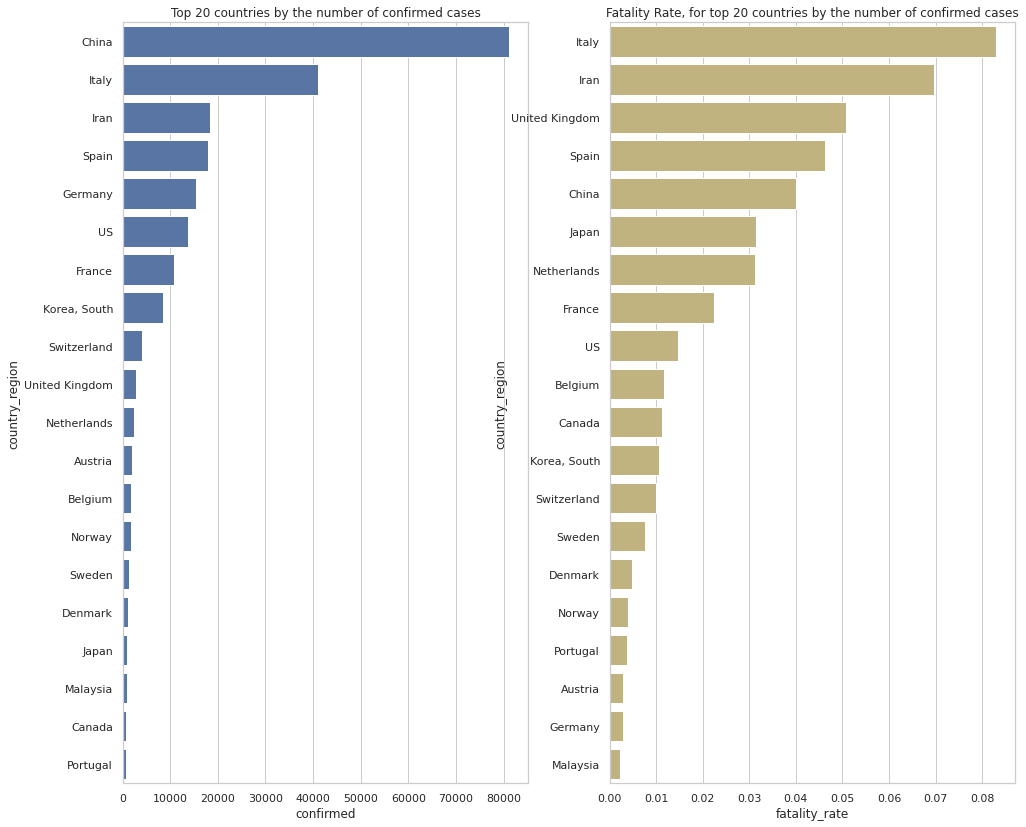

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

df_fatal_rate = df_confirm.sort_values(by='fatality_rate', ascending=False)

# Initialize the matplotlib figure
f, (ax1, ax2) = plt.subplots(figsize=(16, 14), ncols=2)


sns.barplot(x="confirmed", y="country_region", data=df_confirm,
            label="confirmed", color="b",  ax=ax1)
ax1.set_title("Top 20 countries by the number of confirmed cases")

sns.barplot(x="fatality_rate", y="country_region", data=df_fatal_rate,
            label="fatality rate", color="y",  ax=ax2)
ax2.set_title("Fatality Rate, for top 20 countries by the number of confirmed cases")

In [7]:
import plotly.express as px

df['province_state'] = df['province_state'].fillna(df['country_region'])
fig = px.scatter_mapbox(data_frame=df, lat="latitude", lon="longitude", hover_data=["confirmed", "deaths"],  
                        size="confirmed", zoom=2, height=1000, hover_name="province_state" )

fig.update_layout(mapbox_style="open-street-map")
fig.show()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 292 entries, 0 to 318
Data columns (total 9 columns):
province_state    292 non-null object
confirmed         292 non-null int64
deaths            292 non-null int64
recovered         292 non-null int64
latitude          292 non-null float64
longitude         292 non-null float64
date              292 non-null object
country_region    292 non-null object
last_update       292 non-null object
dtypes: float64(2), int64(3), object(4)
memory usage: 32.8+ KB
